In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from geomloss import SamplesLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [6]:
def load_image(path, max_size=None):
    img = Image.open(path).convert("RGB")
    if max_size:
        img.thumbnail(max_size, Image.BILINEAR)
    img = np.array(img, dtype=np.float32) / 255.0
    return img


def image_to_5d(img):
    H, W = img.shape[:2]
    y, x = np.meshgrid(np.linspace(0, 1, H), np.linspace(0, 1, W), indexing="ij")
    pos = np.stack([x.flatten(), y.flatten()], axis=1)  # (N,2)
    col = img.reshape(-1, 3)  # (N,3)
    X = np.concatenate([pos, col], axis=1).astype(np.float32)  # (N,5)
    return X, (H, W)

In [7]:
img_src = load_image("./data/cifar10/automobile/0000.jpg", max_size=(64, 64))
img_tgt = load_image("./data/pixelart/images/image_241.JPEG", max_size=(32, 32))

X_src_np, (H_src, W_src) = image_to_5d(img_src)
X_tgt_np, (H_tgt, W_tgt) = image_to_5d(img_tgt)

X_src = torch.from_numpy(X_src_np).to(device)
X_tgt = torch.from_numpy(X_tgt_np).to(device)

a = torch.ones(X_src.shape[0], device=device) / X_src.shape[0]
b = torch.ones(X_tgt.shape[0], device=device) / X_tgt.shape[0]

print(X_src.shape, X_tgt.shape)

torch.Size([1024, 5]) torch.Size([256, 5])


In [8]:
loss_fn = SamplesLoss(
    loss="sinkhorn",
    p=2,
    blur=0.02,  # epsilon
    reach=0.1,  # rho (unbalanced)
    backend="auto",
    potentials=False,
)

loss = loss_fn(a, X_src, b, X_tgt)

potentials = SamplesLoss(
    loss="sinkhorn",
    p=2,
    blur=0.02,  # epsilon
    reach=0.1,  # rho (unbalanced)
    backend="auto",
    potentials=True,
)

f, g = potentials(a, X_src, b, X_tgt)
print("Unbalanced Sinkhorn divergence:", loss)
print(f"potential {f.shape=}, {g.shape=}")

Unbalanced Sinkhorn divergence: tensor(0.0129)
potential f.shape=torch.Size([1, 1024]), g.shape=torch.Size([1, 256])


In [9]:
def reconstruct_pi_unbalanced(a, X, b, Y, f, g, eps, rho):
    """
    Reconstruit le plan de transport régularisé unbalanced à partir
    des potentiels f, g renvoyés par GeomLoss.
    """
    # f,g : (1,N), (1,M)
    f = f.squeeze(0)
    g = g.squeeze(0)

    C = torch.cdist(X, Y, p=2).pow(2)  # (N,M)

    # terme exponentiel
    log_pi = (f[:, None] + g[None, :] - C) / eps - (f[:, None] + g[None, :]) / rho

    # masses des mesures (a,b) sont optionnelles ici
    pi = torch.exp(log_pi)
    pi = pi / pi.sum()  # normalisation optionnelle
    return pi

In [10]:
def transport_colors(X_src, X_tgt, pi, H_src, W_src):
    col_tgt = X_tgt[:, 2:5]
    mass_out = pi.sum(dim=1, keepdim=True) + 1e-16
    new_colors = (pi @ col_tgt) / mass_out
    img = new_colors.detach().cpu().numpy().reshape(H_src, W_src, 3)
    return np.clip(img, 0, 1)

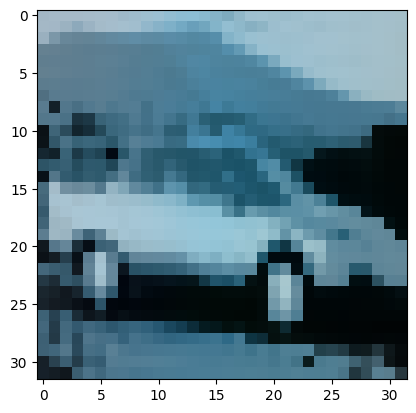

In [11]:
pi = reconstruct_pi_unbalanced(a, X_src, b, X_tgt, f, g, eps=0.02, rho=0.1)
img_transported = transport_colors(X_src, X_tgt, pi, H_src, W_src)
plt.imshow(img_transported)

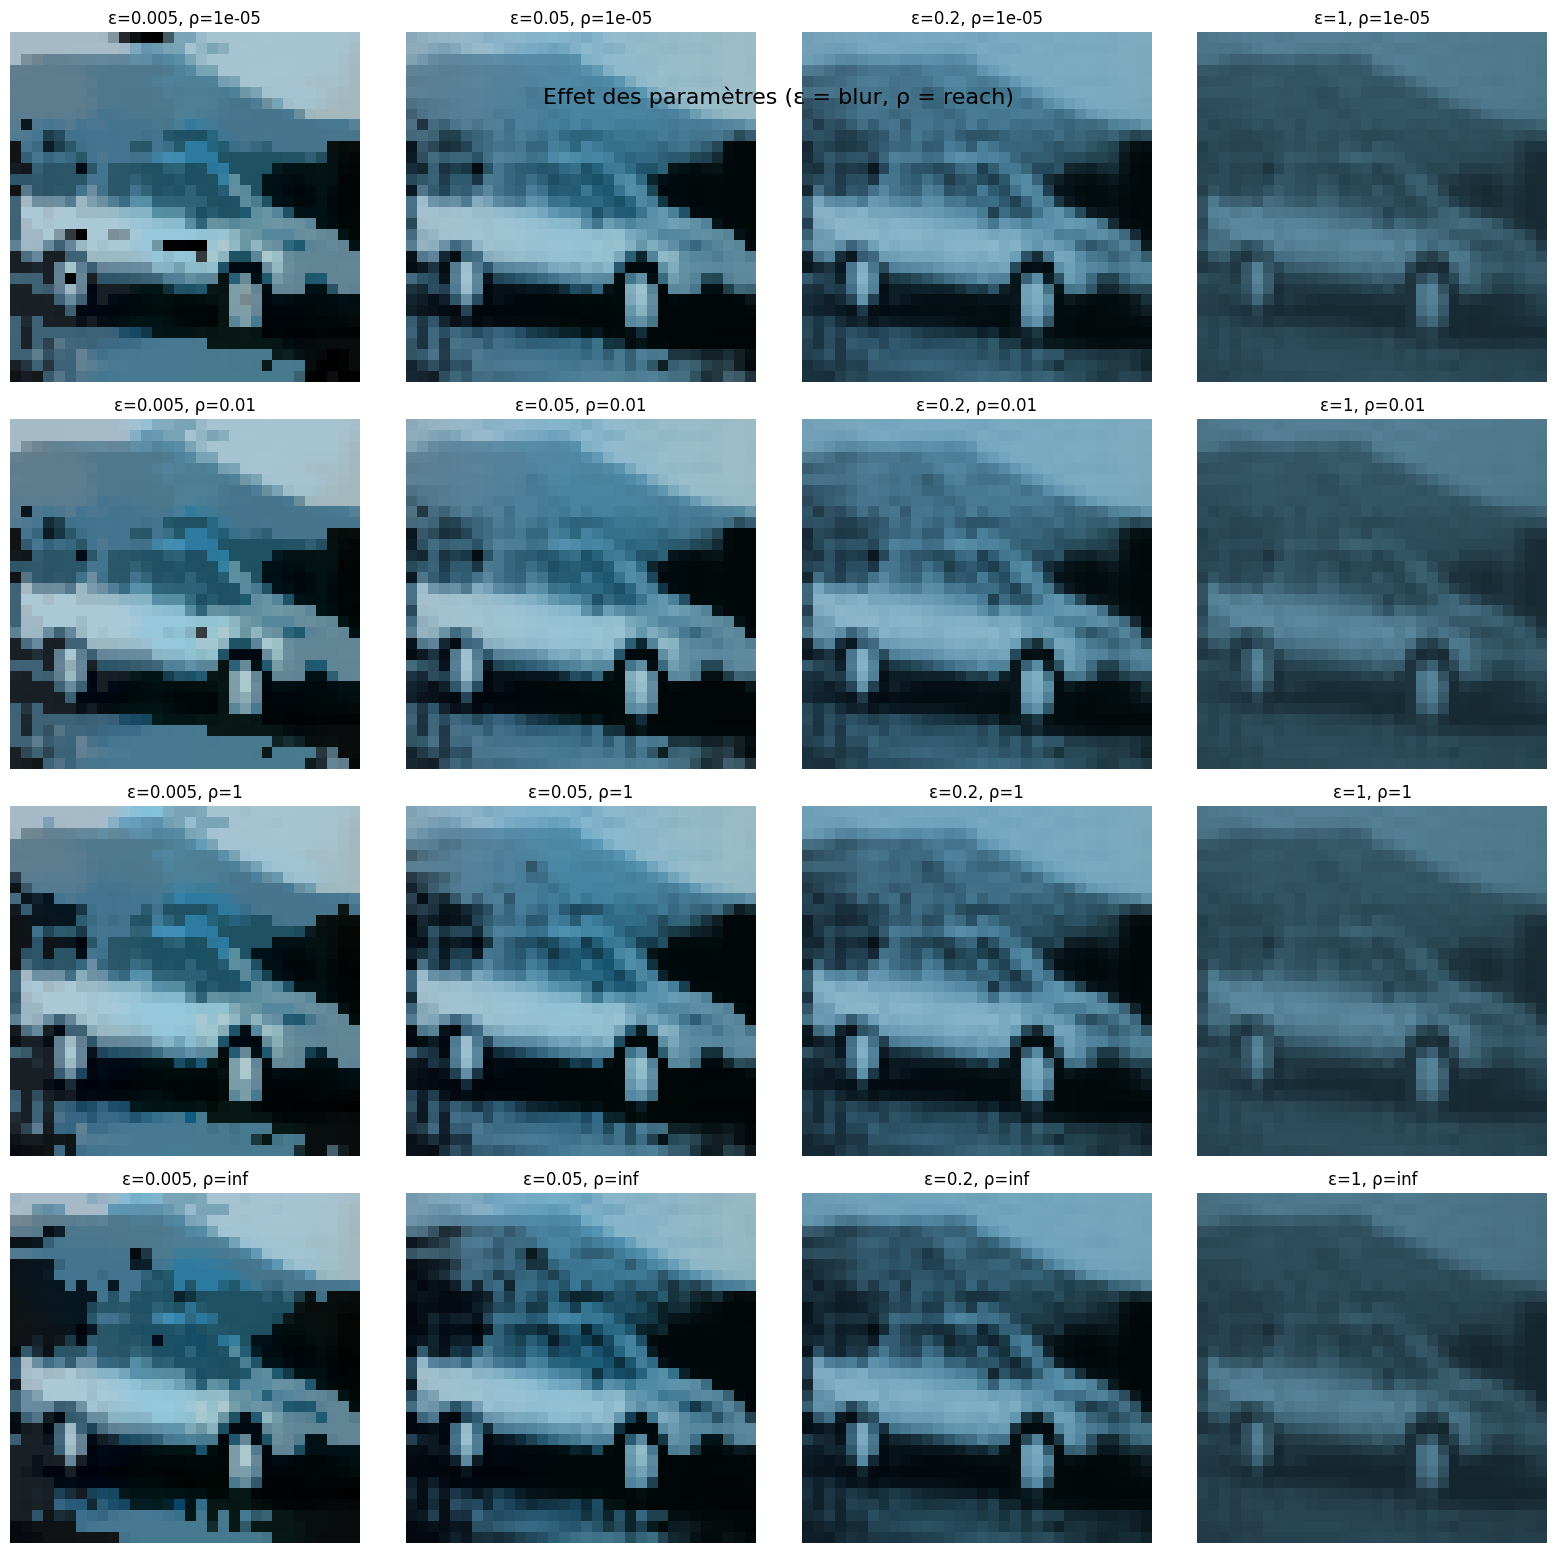

In [12]:
# Listes ajustables de paramètres
eps_list = [0.005, 0.05, 0.2, 1]
rho_list = [0.00001, 0.01, 1, np.inf]

# Création de la grille d'affichage
fig, axes = plt.subplots(
    len(rho_list), len(eps_list), figsize=(4 * len(eps_list), 4 * len(rho_list))
)
fig.suptitle("Effet des paramètres (ε = blur, ρ = reach)", fontsize=16, y=0.92)

for i, rho in enumerate(rho_list):
    for j, eps in enumerate(eps_list):

        # 1. Créer la loss unbalanced avec potentiels
        loss_fn = SamplesLoss(
            loss="sinkhorn", p=2, blur=eps, reach=rho, backend="auto", potentials=True
        )

        # 2. Calculer les potentiels f,g
        f, g = loss_fn(a, X_src, b, X_tgt)

        # 3. Reconstruire π et l'image transportée
        pi = reconstruct_pi_unbalanced(a, X_src, b, X_tgt, f, g, eps, rho)
        img_transport = transport_colors(X_src, X_tgt, pi, H_src, W_src)

        # 4. Affichage
        ax = axes[i, j] if len(rho_list) > 1 else axes[j]
        ax.imshow(img_transport)
        ax.set_title(f"ε={eps}, ρ={rho}")
        ax.axis("off")

plt.tight_layout()
plt.show()